## CASPER: Context-Aware Anomaly Detection System for Industrial Robotic Arms

This notebook contains the work of the demo paper presented in **The 21st International Conference on Pervasive Computing and Communications (PerCom 2023)**.

The GitHub repo of the work:  

Initial steps:

1. Download the dataset from IEEEDataPort: https://ieee-dataport.org/documents/casper-context-aware-anomaly-detection-system-industrial-robotic-arms
2. Extract the `casper.zip` file.

The dataset contains four files:
    * A .csv file that consists of accelerometer, gyroscope, and magnetometer data of an arm that accomplishes a repetitive task, captured via Nicla Sense ME.
    * Two .csv files (one per industrial arm) that consist of built-in arm parameters such as joint current, and velocity values etc.
    * A .pcap file that contains the TCP/IP traffic between the arms and the controller PC.

For this work, you will only need `right_arm.csv` and `nicla.csv`.

The whole test is around 24 hours.

We modify the joint velocity of the **right arm** after 14.4 hours (corresponding to 60%).

You should replace the `file paths` with your own paths.

The cells starts with `%%time` are expected to take longer running times depending on your setup. As the training, takes long time, we provide the saved model for convenience.

We run this experiment on a data science workstation with **NVIDIA RTX A6000**.

Please install the other required libraries given in below cell.

Key versions to match:
* Python version: 3.9.12
* TensorFlow version: 2.9.1

In [22]:
# Import required libraries.
import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import seaborn as sns

from IPython.utils import io
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

Make sure you have access to gpu.

In [2]:
# Check for TensorFlow GPU access.
from psutil import virtual_memory

print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)

# See TensorFlow version.
print(f"TensorFlow version: {tf.__version__}")

# If you are on ARM-based MacOS this will return "command not found".
# In that case, you need to consider the output of above statements.
!nvidia-smi - L
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print("Your runtime has {:.1f} gigabytes of available RAM\n".format(ram_gb))

# This is useful on Google Colab to check if high-RAM is selected.
if ram_gb < 20:
    print("Not using a high-RAM runtime")
else:
    print("You are using a high-RAM runtime!")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.1
/bin/bash: /home/hakan/miniconda3/envs/casper/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Failed to initialize NVML: Driver/library version mismatch
/bin/bash: /home/hakan/miniconda3/envs/casper/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Failed to initialize NVML: Driver/library version mismatch
Your runtime has 134.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

## Dataset Matching

We have two data sources that we need to match:
1. Built-in parameters data that contain the anomaly labels as well.
2. Nicla Sense ME data where we do the anomaly detection.

We should correctly match the anomalous labels we got from the 1st data to 2nd.

#### The reasons for the mismatch in data sources:
1. Even thought we set both freqs to 20Hz with the given available libraries, we see that the freqs differ around **18Hz to 22Hz**.
2. The Nicla stopped after the industrial robotic arm (estimatedly few minutes.)
3. The Nicla started earlier than the industrial robotic arm.

If the freq was exactly **20Hz**, we would had **1728000** data points.

Now we match the data sources based on the **location of the first anomalous point**. 

In [4]:
# If local the path:
NICLA_PATH = "../datasets/nicla.csv"  # Change this accordingly.

# We skip first 6 rows due to faulty format/data.
nicla = pd.read_csv(
    NICLA_PATH,
    on_bad_lines="warn",
    skiprows=6,
    names=["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "MagX", "MagY", "MagZ"],
)

# Check if there are any empty/Nan variables.
if nicla.isnull().values.any():
    raise ValueError("Nan variable is present.")

# Explore the dataframe.
print(nicla.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751682 entries, 0 to 1751681
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   AccX    float64
 1   AccY    float64
 2   AccZ    float64
 3   GyroX   float64
 4   GyroY   float64
 5   GyroZ   float64
 6   MagX    float64
 7   MagY    float64
 8   MagZ    float64
dtypes: float64(9)
memory usage: 120.3 MB
None


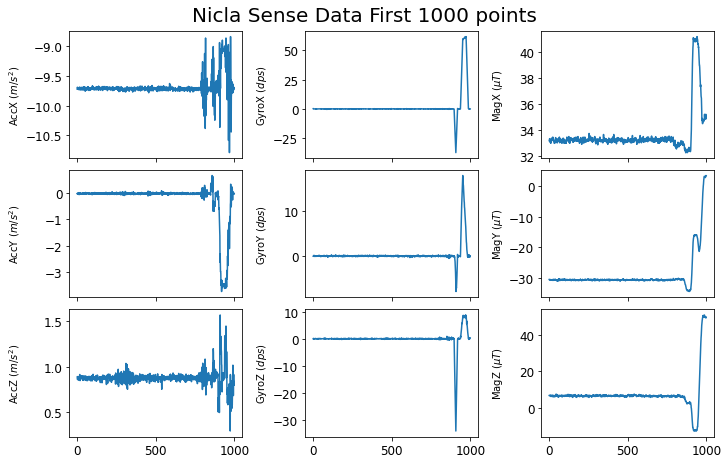

In [5]:
# Visualize the first 1000 point
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(
    3, 3, sharex=True, figsize=(10, 6), constrained_layout=True
)

START_INDEX = 0
END_INDEX = 1000

ax1.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccX"][START_INDEX:END_INDEX])
ax1.set_ylabel(r"AccX $(m/s^2)$")

ax2.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroX"][START_INDEX:END_INDEX])
ax2.set_ylabel(r"GyroX $(dps)$")

ax3.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagX"][START_INDEX:END_INDEX])
ax3.set_ylabel(r"MagX (${\mu}T$)")

ax4.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccY"][START_INDEX:END_INDEX])
ax4.set_ylabel(r"AccY $(m/s^2)$")

ax5.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroY"][START_INDEX:END_INDEX])
ax5.set_ylabel(r"GyroY $(dps)$")

ax6.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagY"][START_INDEX:END_INDEX])
ax6.set_ylabel(r"MagY (${\mu}T$)")

ax7.plot(nicla.index[START_INDEX:END_INDEX], nicla["AccZ"][START_INDEX:END_INDEX])
ax7.set_ylabel(r"AccZ $(m/s^2)$")

ax8.plot(nicla.index[START_INDEX:END_INDEX], nicla["GyroZ"][START_INDEX:END_INDEX])
ax8.set_ylabel(r"GyroZ $(dps)$")

ax9.plot(nicla.index[START_INDEX:END_INDEX], nicla["MagZ"][START_INDEX:END_INDEX])
ax9.set_ylabel(r"MagZ (${\mu}T$)")

fig.align_labels()
plt.suptitle("Nicla Sense Data First 1000 points", x=0.5, y=1.05, fontsize=20)
plt.show()

We see that the Nicla is idle for some time. We now find the **exact starting point**.

In [6]:
# We see that Gyro. noise occurs at range of 0 < x < 1, so we find the first point where x >= 1
index = np.argmax(nicla["GyroX"][:1000].diff().abs() >= 1)
index

898

As the movement starts at (roughly) 898th data point we can **remove the first 897 data points.**

In [7]:
# Drop the first 898 points
nicla_dropped = nicla.iloc[897:]
# Reset the index.
nicla_dropped.index = pd.RangeIndex(len(nicla_dropped.index))

Now, we load the **built-in arm dataset.**

In [9]:
%%time
# Generate df from dataset that contains labels/built-in parameters.
# Path for local PC.
RIGHT_ARM_CSV_PATH = "../datasets/right_arm.csv"

right_arm = pd.read_csv(RIGHT_ARM_CSV_PATH, on_bad_lines="warn")

# Reset Timestamp to 0.
right_arm["Timestamp"] = right_arm["Timestamp"] - right_arm["Timestamp"][0]

CPU times: user 15.9 s, sys: 920 ms, total: 16.9 s
Wall time: 16.9 s


In [10]:
# Get the length of nicla and the other one.
len_nicla_dropped = len(nicla_dropped)
len_right_arm = len(right_arm)

print(f"The length of the right arm data is {len_right_arm}")
print(f"The length of the nicla data is {len_nicla_dropped}")

The length of the right arm data is 1762650
The length of the nicla data is 1750785


As we see the lengths **do not match**. The **final point** of built-in dataset is an **anomaly**, that is how we can locate the **exact end of the 24 hour period.**

Now, we find the final **1** which corresponds to an anomaly.

In [11]:
# Find the final 1.
df_labels = right_arm["Anomaly State"]
index_list = np.where(df_labels == 1)
index_of_last_one = index_list[0][-1]
print(f"The final 1 is located at: {index_of_last_one}")

The final 1 is located at: 1728006


Well, this makes sense, because the **24 hour data at 20Hz means 1728000 data points**. We only have **6 extra** data points in this case.

We now **match the datasets**.

In [12]:
# Remove the rest of the datasets.
# As both data nearly started at the same time, we can match from the beginning.
right_arm = right_arm[0:1728006]
nicla_dropped = nicla_dropped[0:1728006]
n = len(nicla_dropped)
n_arm = len(right_arm)
print(f"The length of Nicla data is {n}")
print(f"The length of arm data is {n_arm}")

The length of Nicla data is 1728006
The length of arm data is 1728006


## The Model Training

Now that we match the datasets, we will move into ML part.

The neural network architecture, that we use in this setup is shown below.

![alt text](./figures/neuralNetworkArch.png "Title")



Due to different scales, we normalize the data and then split into training, validation, and test.

Data are normalized with training parameters so the validation and test sets do not have access to future values.

In [13]:
def get_normalized(d_f, x_minimum, x_maximum, train_per, val_per):
    """
    This function normalize the dataframe and splits into training, validation and test sets.

    Args:
        x_min (float): Min normalization parameter.
        x_max (float): Max normalization parameter.
        train_per (float): Train data ratio, starts from the beginning.
        val_per (float): Validation data ratio, starts after training set.

    Returns:
        dataframe(s): Normalized train, validation, and test dataframes.
    """
    df_len = len(d_f)
    train_nicla_df = d_f[0 : int(df_len * train_per)]
    val_nicla_df = d_f[int(df_len * train_per) : int(df_len * (val_per + train_per))]
    test_nicla_df = d_f[int(df_len * (val_per + train_per)) :]
    scaler = MinMaxScaler(feature_range=(x_minimum, x_maximum))
    _ = scaler.fit(train_nicla_df)
    train_normalized = pd.DataFrame(
        scaler.transform(train_nicla_df), columns=train_nicla_df.columns
    )
    val_normalized = pd.DataFrame(
        scaler.transform(val_nicla_df), columns=train_nicla_df.columns
    )
    test_normalized = pd.DataFrame(
        scaler.transform(test_nicla_df), columns=train_nicla_df.columns
    )
    return train_normalized, val_normalized, test_normalized


X_MIN = 0
X_MAX = 1
TRAIN_RAT = 0.6
VAL_RAT = 0.2
df_train, df_val, df_test = get_normalized(
    nicla_dropped, X_MIN, X_MAX, TRAIN_RAT, VAL_RAT
)

Now we analyze that how data correlate to decide the input window length.

In [14]:
%%time

# Find autocorrelation example.


def df_autocorr(d_f, lag=1, axis=0):
    """
    Compute full-sample column-wise autocorrelation for a DataFrame.
    Returns:
        dataframe: Correlated dataframe.
    """
    return d_f.apply(lambda col: col.autocorr(lag), axis=axis)


def df_rolling_autocorr(d_f, window, lag=1):
    """
    Compute rolling column-wise autocorrelation for a DataFrame.
    Returns:
        dataframe: Correlated dataframe.
    """
    return d_f.rolling(window=window).corr(d_f.shift(lag))


# """"""


def df_autocorr_highest(d_f, window_min, window_max, lag_f):
    """
    Returns a dataframe that contains highest mean correlation with respect to window length.
    Args:
        df (dataframe): Input dataframe.
        window_min (int): Start index of the dataframe subjected to autocorrelation calculation.
        window_max (int): End index of the dataframe subjected to autocorrelation calculation.
        lag_f (int): Correlation lag.

    Returns:
        Dic: A dictionary with Pearson correlation coefficients and corresponding window length.
    """
    df_corrs = pd.DataFrame()
    df_corr_dict = {}
    for i in range(len(d_f.columns)):
        corr_init = 0
        corr_index = 0
        for j in range(window_min, window_max):
            corr = (
                df_rolling_autocorr(d_f.iloc[:, i], window=j, lag=lag_f).dropna().mean()
            )
            if corr > corr_init:
                corr_init = corr
                corr_index = j
        corr_label = d_f.columns[i] + "_corr"
        df_corrs[corr_label] = [corr_init, corr_index]
        df_corr_dict[corr_label] = [corr_init, corr_index]
    return df_corr_dict


# We determine the window paratemers (600 and 1201) via grid search.
df_corr_train = df_autocorr_highest(df_train, 600, 800, 1)

pprint(df_corr_train)

{'AccX_corr': [0.494675099562637, 755],
 'AccY_corr': [0.9772278901518688, 755],
 'AccZ_corr': [0.44800133282688587, 755],
 'GyroX_corr': [0.9975431207556662, 755],
 'GyroY_corr': [0.995150209857905, 755],
 'GyroZ_corr': [0.9913403062869746, 751],
 'MagX_corr': [0.9967670161200552, 755],
 'MagY_corr': [0.9996415249638697, 755],
 'MagZ_corr': [0.9989744654946575, 755]}
CPU times: user 2min 48s, sys: 24.8 s, total: 3min 13s
Wall time: 3min 13s


As we see from above, data autocorrelate best when the input window length is 755.

Now, we apply data windowing. We utilize the methods provided by [TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series).

The features of our data window:
* Input width = 755
* Offset = 1
* Label width = 1

In [19]:
MAX_EPOCHS = 100
LABEL_WIDTH = 1
MAX_POOL_KERNEL_SIZE = 3
NUM_FILTERS = 32
ACTIVATION = "relu"
CONV_WIDTH = 755
KERNEL_SIZE = 5


class TimeHistory(tf.keras.callbacks.Callback):
    """Allows us to callback epoch time."""
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


time_callback = TimeHistory()


def compile_and_fit(model, window, patience=10):
    """
    Compiles and fits the model.
    Args:
        model (keras.engine.sequential.Sequential): Keras model.
        window (__main__.WindowGenerator): Input window.
        patience (int, optional): Stops training if model does not improve
        after nth epoch. Defaults to 10.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adamax(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    his = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping, time_callback],
    )
    return his


def make_dataset(self, data):
    """Check TensorFlow link for explanation."""
    data = np.array(data, dtype=np.float32)
    d_s = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=256,
    )

    d_s = d_s.map(self.split_window)

    return d_s


def split_window(self, features):
    """Check TensorFlow link for explanation."""
    inputs = features[:, self.input_slice, :]
    label_s = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        label_s = tf.stack(
            [label_s[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    label_s.set_shape([None, self.label_width, None])

    return inputs, label_s


@property
def train(self):
    """Check Tensorflow Link for explanation."""
    return self.make_dataset(self.train_df)


@property
def val(self):
    """Check Tensorflow Link for explanation."""
    return self.make_dataset(self.val_df)


@property
def test(self):
    """Check Tensorflow Link for explanation."""
    return self.make_dataset(self.test_df)


class WindowGenerator:
    """Check Tensorflow Link for explanation."""

    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=df_train,
        val_df=df_val,
        test_df=df_test,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.split_window = split_window

conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=None
)

conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=NUM_FILTERS, kernel_size=(KERNEL_SIZE,), activation=ACTIVATION
        ),
        tf.keras.layers.Conv1D(
            filters=NUM_FILTERS, kernel_size=(KERNEL_SIZE,), activation=ACTIVATION
        ),
        tf.keras.layers.MaxPool1D(pool_size=MAX_POOL_KERNEL_SIZE),
        tf.keras.layers.Conv1D(
            filters=NUM_FILTERS, kernel_size=(KERNEL_SIZE,), activation=ACTIVATION
        ),
        tf.keras.layers.Conv1D(
            filters=NUM_FILTERS, kernel_size=(KERNEL_SIZE,), activation=ACTIVATION
        ),
        tf.keras.layers.MaxPool1D(pool_size=MAX_POOL_KERNEL_SIZE),
        tf.keras.layers.Flatten(),
        # We have 9 features to predict.
        tf.keras.layers.Dense(units=9),
        # We add the time back.
        tf.keras.layers.Reshape([1, -1]),
    ]
)

print(type(conv_window))

<class '__main__.WindowGenerator'>


Run the below cell only if you want to do the training assumed you ignored the above cell. To run uncomment the `history` line.

In [20]:
%%time
val_performance = {}
performance = {}
history = compile_and_fit(conv_model, conv_window)
val_performance["Conv"] = conv_model.evaluate(
    conv_window.val, verbose=1, return_dict=False
)
performance["Conv"] = conv_model.evaluate(
    conv_window.test, verbose=1, return_dict=False
)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

conv_model.save("conv_model")

Epoch 1/100
4048/4048 [==============================] - 63s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0210 - val_loss: 0.0033 - val_mean_absolute_error: 0.0298
Epoch 2/100
4048/4048 [==============================] - 63s 16ms/step - loss: 8.4574e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0030 - val_mean_absolute_error: 0.0286
Epoch 3/100
4048/4048 [==============================] - 63s 15ms/step - loss: 8.0890e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0026 - val_mean_absolute_error: 0.0263
Epoch 4/100
4048/4048 [==============================] - 63s 16ms/step - loss: 7.8558e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0024 - val_mean_absolute_error: 0.0258
Epoch 5/100
4048/4048 [==============================] - 63s 16ms/step - loss: 7.7013e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0022 - val_mean_absolute_error: 0.0238
Epoch 6/100
4048/4048 [==============================] - 63s 15ms/step - loss: 7.5993e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0021 

INFO:tensorflow:Assets written to: conv_model/assets


INFO:tensorflow:Assets written to: conv_model/assets


CPU times: user 12h 35min 3s, sys: 3h 6min 17s, total: 15h 41min 20s
Wall time: 1h 44min 35s


We save the loss values for later use. Uncomment only if you do the training.

In [34]:
# Save loss values to a file.
with open('loss.txt', 'wb') as fp:
    pickle.dump(loss, fp)
with open('val_loss.txt', 'wb') as fp:
    pickle.dump(val_loss, fp)

Load the saved loss values. Uncomment only if you do not do the training.

In [36]:
# Load the pre-saved loss values.
# with open ('loss.txt', 'rb') as fp:
#     loss = pickle.load(fp)
# with open ('val_loss.txt', 'rb') as fp2:
#     val_loss = pickle.load(fp2)

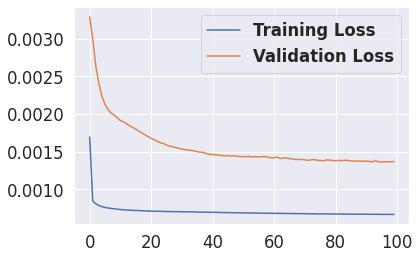

In [78]:
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
legend_properties = {'weight':'bold'}
plt.legend(loc="upper right", prop=legend_properties)
plt.savefig('figures/lossGraph.pdf')

If you do not do the training you can load the model we provide, via the below example cell, and then predict. Uncomment to do that.

In [ ]:
# conv_model = tf.keras.models.load_model("conv_model")
# conv_model.summary()

## The Baseline

In [73]:
PERIOD = 755

def mae(data, period):
    """
    Calculates mean absolute error (MAE) overall dataset.
    Args:
        dataset (numpy.Array): An array that contains parameter to be used when calculating MAE.
        period (integer): Number of data points in one periodic window.
    Returns:
        MAE per feature, MAE overall.
    """
    number_of_windows = int(len(data) / period)
    num_rows, num_cols = data.shape
    sum_mae = np.zeros(num_cols)
    for i in range(number_of_windows - 1):
        diff_window = data[period*i:period*(i+1)] - data[period*(i+1):period*(i+2)]
        diff_window_abs = np.absolute(diff_window)
        sum_diff = diff_window_abs.sum(axis=0)
        mae_window = sum_diff / period
        sum_mae = sum_mae + mae_window
    
    final_mae_per_feature = sum_mae / (number_of_windows - 1)
    final_mae_overall = np.mean(final_mae_per_feature)
    return final_mae_per_feature, final_mae_overall

print(f"The MAE of train {mae(df_train.to_numpy(), PERIOD)}")
print(f"The MAE of validation {mae(df_val.to_numpy(), PERIOD)}")
print(f"The MAE of test {mae(df_test, PERIOD)}")

The MAE of train (array([0.04276141, 0.03086297, 0.04765034, 0.00550876, 0.00683059,
       0.00823718, 0.01227732, 0.00446184, 0.00781189]), 0.018489143100713833)
The MAE of validation (array([0.04692985, 0.05295689, 0.05873922, 0.03945174, 0.03093915,
       0.03330484, 0.03167815, 0.02263045, 0.03070723]), 0.03859305650667221)
The MAE of test (array([0.04950482, 0.07017163, 0.05402572, 0.03705385, 0.02830081,
       0.03151123, 0.04545084, 0.04528223, 0.04831509]), 0.04551291208360275)


## The Anomaly Detection

In [59]:
%%time
# Predict the test data.
predictions_list = []
with io.capture_output() as captured:
    for sample_inputs, sample_labels in conv_window.test.take(-1):
        preds = conv_model.predict(sample_inputs).tolist()
        for i in range(len(preds)):
            # predictions = scaler.inverse_transform(preds[i])
            predictions = preds[i]
            # predictions_list.append(predictions[0].tolist())
            predictions_list.append(predictions[0])

We cannot predict the first 755 one due to lack of previous data.

In [60]:
print(f"Length of the test data: {len(df_test)}")
print(f"Length of the predicted data: {len(predictions_list)}")

Length of the test data: 345602
Length of the predicted data: 344847


In [62]:
# Convert assets to numpy arrays.
if type(df_test) != np.ndarray:
    df_test = df_test.to_numpy()[755:]
if type(predictions_list) != np.ndarray:
    predictions_list = np.array(predictions_list)

# Verify the lengths.
if len(df_test) == len(predictions_list):
    print("Lengths match.")
else:
    raise ValueError("Check lengths.")

# Calculate residuals.
# 100 for easy examination.
residuals = np.sum(abs(np.subtract(df_test, predictions_list)), axis=1)
# Convert points into windows.
residuals = pd.DataFrame(residuals).rolling(755).sum().dropna().reset_index(drop=True)
# Get labels.
labels = right_arm["Anomaly State"][-344847:].reset_index(drop=True).to_numpy()
# Convert single labels into windows.
labels = pd.DataFrame(labels).rolling(755).sum().dropna().reset_index(drop=True)

# If the sum is over 377.5 (half of the window) we accept as an anomaly.
labels[:] = np.where(labels > 377.5, 1, np.where(labels < 377.5, 0, labels))

# Fix the mismatching via shifting.
labels = np.roll(labels, -11059)

# Verify the lengths.
if len(labels) == len(residuals):
    print("Lengths match.")
else:
    raise ValueError("Check lengths.")

Lengths match.
Lengths match.


Now we get the labels from the right arm data.

In [63]:
# Save the files for further examination if needed.
np.savetxt("residuals.txt", residuals)
np.savetxt("labels.txt", labels)

In [64]:
# Find the mean of absolute errors.
threshold_mean = residuals.mean()
print(f"Residual mean: {threshold_mean}")

# Find the median of absolute errors.
threshold_median = residuals.median()
print(f"Residual median: {threshold_median}")

Residual mean: 0    156.055272
dtype: float64
Residual median: 0    96.960498
dtype: float64


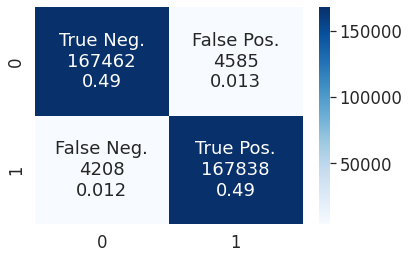

{'Median': {'accuracy': 0.9744458620198609,
            'f1': 0.9744737552580929,
            'precision': 0.9734084199903725,
            'recall': 0.9755414249677412}}


In [74]:
# Convert in a way to return accuracy etc.
def gen_conf_matrix(anomalies, residual_s, threshold):
    """
    Returns confusion matrix parameters.
    Args:
        anomalies (numpy.ndarray): Numpy array which contains anomalies.
        residuals (numpy.ndarray): Numpy array which contains residuals.
        threshold (float): Threshold value. Above threshold will be considered as anomaly.

    Returns:
        accuracy, f1, recall, precision: _description_
    """
    res = np.where(residual_s <= threshold, 0, 1)
    cfm = confusion_matrix(res, anomalies)
    t_n, f_p, f_n, t_p = confusion_matrix(res, anomalies).ravel()
    accuracy = (t_p + t_n) / (t_p + t_n + f_p + f_n)
    f1 = (2 * t_p) / (2 * t_p + f_p + f_n)
    recall = t_p / (t_p + f_n)
    precision = t_p / (t_p + f_p)
    group_names = ["True Neg.", "False Pos.", "False Neg.", "True Pos."]
    group_counts = ["{0:0.0f}".format(value) for value in cfm.flatten()]

    group_percentages = [
        "{0:.2}".format(value) for value in cfm.flatten() / np.sum(cfm)
    ]

    labelss = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labelss = np.asarray(labelss).reshape(2, 2)
    sns.set(font_scale=1.5)
    sns.heatmap(cfm, annot=labelss, fmt="", cmap="Blues")
    plt.savefig("figures/cm.pdf")
    plt.show()
    return accuracy, f1, recall, precision


accuracy_med, f1_med, recall_med, precision_med = gen_conf_matrix(
    labels, residuals, threshold_median
)

results = {
    "Median": {
        "accuracy": accuracy_med,
        "f1": f1_med,
        "recall": recall_med,
        "precision": precision_med,
    },
}
pprint(results)

Using medium as a threshold allows us to reach around 98% accuracy.